In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
from torch.autograd import grad as torch_grad

In [2]:
def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()

# Design Generator and Dicriminator

In [3]:
class Generator(nn.Module):
    """docstring for Generator."""
    def __init__(self):
        super(Generator, self).__init__()
        self.d = 128
        self.Tconv1 = nn.ConvTranspose2d(100, self.d * 8, 4, 1, 0) #(batch, 4, 4, 1024)
        self.batch1 = nn.BatchNorm2d(self.d * 8)
        self.Tconv2 = nn.ConvTranspose2d(self.d * 8, self.d * 4, kernel_size=4, stride=2, padding=1) #(B, 8, 8, 512)
        self.batch2 = nn.BatchNorm2d(self.d * 4)
        self.Tconv3 = nn.ConvTranspose2d(self.d * 4, self.d * 2, kernel_size=4, stride=2, padding=1) #(B, 16, 16, 256)
        self.batch3 = nn.BatchNorm2d(self.d * 2)
        self.Tconv4 = nn.ConvTranspose2d(self.d * 2, self.d, kernel_size=4, stride=2, padding=1) #(B, 32, 32, 256)
        self.batch4 = nn.BatchNorm2d(self.d)
        self.Tconv5 = nn.ConvTranspose2d(self.d, 1, kernel_size=4, stride=2, padding=1) #(B, 64, 64, 256)
        
        
    def forward(self, z):
        z_conv = F.relu(self.batch1(self.Tconv1(z)))
        z_conv = F.relu(self.batch2(self.Tconv2(z_conv)))
        z_conv = F.relu(self.batch3(self.Tconv3(z_conv)))
        z_conv = F.relu(self.batch4(self.Tconv4(z_conv)))
        z_conv = F.tanh(self.Tconv5(z_conv))
        return z_conv
    
    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

class Discriminator(nn.Module):
    """docstring for Discriminator."""
    def __init__(self):
        super(Discriminator, self).__init__()
        self.d = 128
        self.conv2D1 = nn.Conv2d(1, self.d, kernel_size=4, stride=2, padding=1)
        self.conv2D2 = nn.Conv2d(self.d, self.d * 2, kernel_size=4, stride=2, padding=1)
        self.batch2 = nn.BatchNorm2d(self.d * 2)
        self.conv2D3 = nn.Conv2d(self.d * 2, self.d * 4, kernel_size=4, stride=2, padding=1)
        self.batch3 = nn.BatchNorm2d(self.d*4)
        self.conv2D4 = nn.Conv2d(self.d * 4, self.d * 8, kernel_size=4, stride=2, padding=1)
        self.batch4 = nn.BatchNorm2d(self.d * 8)
        self.conv2D5 = nn.Conv2d(self.d * 8, 1, kernel_size=4, stride=2, padding=0)

    def forward(self, x):
        x_conv = F.leaky_relu(self.conv2D1(x), 0.2)
        x_conv = F.leaky_relu(self.batch2(self.conv2D2(x_conv)), 0.2)
        x_conv = F.leaky_relu(self.batch3(self.conv2D3(x_conv)), 0.2)
        x_conv = F.leaky_relu(self.batch4(self.conv2D4(x_conv)), 0.2)
        pred = F.sigmoid(self.conv2D5(x_conv))
        return pred
    
    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

def calc_gradient_penalty(D, real_data, generated_data, LAMDA):
    batch_size = real_data.size()[0]
    use_cuda = True
    
    # Calculate interpolation
    alpha = torch.rand(batch_size, 1, 1, 1)
    alpha = alpha.expand_as(real_data)
    if use_cuda:
        alpha = alpha.cuda()
    interpolated = alpha * real_data.data + (1 - alpha) * generated_data.data
    interpolated = Variable(interpolated, requires_grad=True)
    
    if use_cuda:
        interpolated = interpolated.cuda()
    # Calculate probability of interpolated examples
    prob_interpolated = D(interpolated)
    # Calculate gradients of probabilities with respect to examples
    gradients = torch_grad(outputs=prob_interpolated, inputs=interpolated,
                            grad_outputs=torch.ones(prob_interpolated.size()).cuda() if use_cuda else torch.ones(
                            prob_interpolated.size()),
                            create_graph=True, retain_graph=True)[0]
    
    # Gradients have shape (batch_size, num_channels, img_width, img_height),
    # so flatten to easily take norm per example in batch
    gradients = gradients.view(batch_size, -1)


    # Derivatives of the gradient close to 0 can cause problems because of
    # the square root, so manually calculate norm and add epsilon
    gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12)
    # Return gradient penalty
    return LAMDA * ((gradients_norm - 1) ** 2).mean()

# Test Generator and Discriminator

In [4]:
z = torch.randn(100, 100).view(100, 100, 1, 1)    # fixed noise
z = Variable(z)
generator_test = Generator()
z_conv = generator_test.forward(z)
print(z_conv.size())

torch.Size([100, 1, 64, 64])


In [5]:
discrimintaor_test = Discriminator()
pred_z_conv = discrimintaor_test(z_conv)
print(pred_z_conv.size())

torch.Size([100, 1, 1, 1])


# Load dataset

In [6]:
# MNIST dataset

#transform = transforms.Compose(
#    [torchvision.transforms.Resize((64, 64)),
#        transforms.ToTensor()],)

transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

dataset = torchvision.datasets.MNIST(root='./data',
                         train=True,
                         transform=transform,
                         download=True)

# Data loader
data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                          batch_size=128, 
                                          shuffle=True)

# Test on images

torch.Size([128, 1, 64, 64])


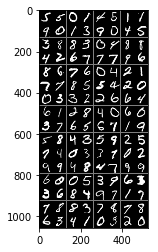

In [7]:
# get some random training images
dataiter = iter(data_loader)
images, labels = dataiter.next()
print(images.size())
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# show images
imshow(torchvision.utils.make_grid(images))
plt.show()

In [8]:
img = Variable(images)
print(img.size())
pred_img_conv = discrimintaor_test(img)
print(pred_img_conv.size())

torch.Size([128, 1, 64, 64])
torch.Size([128, 1, 1, 1])


In [9]:
img = Variable(images)
print(img.size())
pred_img_conv = discrimintaor_test(img)
print(pred_img_conv.size())

torch.Size([128, 1, 64, 64])
torch.Size([128, 1, 1, 1])


# Design model

In [10]:
def extract(v):
    return v.data.storage().tolist()
d_learning_rate = 0.0001
g_learning_rate = 0.0001
n_epoch = 20

In [11]:
#Define network
G = Generator()
D = Discriminator()
G.cuda()
D.cuda()
G.weight_init(mean=0.0, std=0.02)
D.weight_init(mean=0.0, std=0.02)

#Define Learning
d_optimizer = optim.Adam(D.parameters(), lr=d_learning_rate, betas=(0, 0.9))
g_optimizer = optim.Adam(G.parameters(), lr=g_learning_rate, betas=(0, 0.9))
G_loss = []
D_loss = []

n_critic = 5
LAMBDA = 10

# Training

In [12]:
for epoch in range(n_epoch):
    for i, data in enumerate(data_loader):
        for _ in range(n_critic):
            D.zero_grad()

            #Compute gradient fake data
            img, _ = data
            batch_size = img.size()[0]
            real_data = Variable(img.cuda())
            real_err = torch.mean(D(real_data))

            #compute grad fake data
            z = torch.randn(batch_size, 100).view(batch_size, 100, 1, 1) 
            d_noise = Variable(z.cuda(), volatile = False) 
            fake_output = G(d_noise).detach()
            fake_err = torch.mean(D(fake_output))

            gradient_penalty = calc_gradient_penalty(D, real_data.data, fake_output.data, LAMBDA)
            
            d_err = -(real_err - fake_err - gradient_penalty) #minimize the opposite function
            d_err.backward()
            d_optimizer.step()
            # Weight Clipping
            #for param in D.parameters():
                #param.data.clamp_(-0.01, 0.01)

        G.zero_grad()

        z = torch.randn(batch_size, 100).view(batch_size, 100, 1, 1)     # fixed noise
        g_noise = Variable(z.cuda())
        g_fake_data = G(g_noise)
        g_err = -torch.mean(D(g_fake_data))
        g_err.backward()
        g_optimizer.step()
        
        G_loss.append(extract(g_err)[0])
        D_loss.append(extract(real_err - fake_err)[0])



    print("%s: D: %s G: %s " % (epoch + 1,
                                        extract(real_err - fake_err)[0],
                                        extract(g_err)[0],
                                        ))

1: D: -0.0004929900169372559 G: -0.9999995827674866 
2: D: -0.9999996423721313 G: -0.9999980926513672 


KeyboardInterrupt: 

# Results

In [ ]:
w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    z = torch.randn((128, 100)).view(128, 100, 1, 1)     # fixed noise
    z = Variable(z.cuda())
    images = G(z)
    img = images.cpu().data
    fig.add_subplot(rows, columns, i)
    imshow(torchvision.utils.make_grid(img[0].view(64,64)))
plt.show()
fig.savefig('WDCGAN_20epochs.png', bbox_inches='tight')

In [ ]:
z = torch.randn((128, 100)).view(128, 100, 1, 1)     # fixed noise
z = Variable(z.cuda())
images = G(z)
img = images.cpu().data
imshow(torchvision.utils.make_grid(img[0].view(64,64)))
plt.show()

In [ ]:
absc = np.linspace(0, len(G_loss), len(G_loss))
fig=plt.figure(figsize=(15, 7))
plt.plot(absc, G_loss, label = "G_loss")
plt.plot(absc, D_loss, label = "D_loss")
plt.title("Losses evolution")
plt.ylabel("Loss value")
plt.xlabel("Iterations(%batch_size)")
plt.legend()
plt.show()
fig.savefig('loss_WDCGAN_20epochs.png', bbox_inches='tight')